In [2]:
import numpy as np
import keras
from keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
import json
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from aeon.classification.hybrid import HIVECOTEV2

In [5]:
file_path = './combined_all_interpol_synced_4sec_800samples_prot4.pkl'

dataFrame = pd.read_pickle(file_path)


print(dataFrame.columns)
y = np.array(dataFrame['uid'])
x = None
for col in dataFrame.columns:
    if 'sensordata' in col:
        if x is None:
            x = np.array(dataFrame[col].apply(lambda x: np.array(x)).to_list())
            #print(x_data.shape)
        else:
            x_data = np.array(dataFrame[col].apply(lambda x: np.array(x)).to_list())
            #print(x_data.shape)
            x = np.append(x, x_data , axis=2)
dur = np.array(dataFrame['duration'])
print("Dataset shapes: ")
print(x.shape)
print(dur.shape)
print(y.shape)

print("number of samples per class: ")
print(np.unique(y, return_counts=True))

def split_features_and_adjust_labels(x, y, window_size=100, overlap=0.4):
    num_samples = x.shape[0]
    num_timesteps = x.shape[1]
    num_features = x.shape[2]

    step_size = int(window_size * (1 - overlap))
    num_segments = int((num_timesteps - window_size) / step_size) + 1

    split_x = np.zeros((num_samples * num_segments, window_size, num_features))
    adjusted_y = np.repeat(y, num_segments)

    segment_index = 0
    for sample_index in range(num_samples):
        for i in range(0, num_timesteps - window_size + 1, step_size):
          split_x[segment_index] = x[sample_index, i : i + window_size, :]
          segment_index += 1

    return split_x, adjusted_y, num_segments

def get_aligned_and_rest(split_x, adjusted_y,num_segments):
    x_aligned = []
    y_aligned = []
    x_not_aligned = []
    y_not_aligned = []

    for i in range(len(adjusted_y)):
        if i % num_segments == 0:
            x_aligned.append(split_x[i])
            y_aligned.append(adjusted_y[i])
        else:
            x_not_aligned.append(split_x[i])
            y_not_aligned.append(adjusted_y[i])
    return np.array(x_aligned), np.array(y_aligned), np.array(x_not_aligned), np.array(y_not_aligned)


split_x, adjusted_y,num_segments  = split_features_and_adjust_labels(x,y,window_size=100,overlap=0)
print(split_x.shape, adjusted_y.shape)
x_aligned, y_aligned, x_not_aligned, y_not_aligned = get_aligned_and_rest(split_x,adjusted_y, num_segments)


y_aligned = y_aligned.astype(str)
y_not_aligned = y_not_aligned.astype(str)
x = x_aligned
y = y_aligned


class_label_encoder = LabelEncoder()


y = class_label_encoder.fit_transform(y)
y_not_aligned = class_label_encoder.transform(y_not_aligned)
n_classes = class_label_encoder.classes_.shape[0]

Index(['uid', 'sensordata.ACC', 'sensordata.GYR', 'sensordata.GRV',
       'sensordata.MAG', 'sensordata.ROT', 'duration'],
      dtype='object', name='stype')
Dataset shapes: 
(332, 800, 17)
(332,)
(332,)
number of samples per class: 
(array(['0112', '0113', '0114', '90001', '90002', '90003', '90004',
       '90005', '90006', '90007', '90010'], dtype=object), array([52, 51, 51, 20, 29, 17, 28, 24, 34, 15, 11]))
(2656, 100, 17) (2656,)


In [97]:
#defined custom class, for loading
@keras.saving.register_keras_serializable()
class Autoencoder(Model):
  def __init__(self, latent_dim, mLength, dims, **kwargs):
      super(Autoencoder, self).__init__(**kwargs)
      self.latent_dim = latent_dim
      self.mLength = mLength
      self.dims = dims
      self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(self.latent_dim, activation='relu'),
      ])
      self.decoder = tf.keras.Sequential([
          layers.Dense(self.mLength * self.dims, activation='linear'),
          layers.Reshape((self.mLength, self.dims)),
      ])

  def call(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

  def get_config(self):
      # Include all parameters needed for re-creation
      config = super(Autoencoder, self).get_config()
      config.update({
          "latent_dim": self.latent_dim,
          "mLength": self.mLength,
          "dims": self.dims,
      })
      return config

  @classmethod
  def from_config(cls, config):
      # Return an instance of the model
      return cls(**config)


In [7]:
all_scaler = StandardScaler()
target_scaler = StandardScaler()
other_scaler = StandardScaler()
all_labels = class_label_encoder.transform(class_label_encoder.classes_)
target_label = [0]
negative_label = all_labels[all_labels != target_label]
#negative_label = [3,4,5,5,6,7,8,9,10]
x_target = x[np.isin(y, target_label)]
y_target = y[np.isin(y, target_label)]
x_other = x[np.isin(y, negative_label)]
y_other = y[np.isin(y, negative_label)]




all_x_train, all_x_test, all_y_train, all_y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)
all_x_train = all_scaler.fit_transform(all_x_train.reshape(-1, all_x_train.shape[-1])).reshape(all_x_train.shape)
all_x_test = all_scaler.transform(all_x_test.reshape(-1, all_x_test.shape[-1])).reshape(all_x_test.shape)

target_x_train, target_x_test, target_y_train, target_y_test = train_test_split(x_target,
                                                    y_target,
                                                    test_size=0.33,
                                                    random_state=42)
target_x_train = target_scaler.fit_transform(target_x_train.reshape(-1, target_x_train.shape[-1])).reshape(target_x_train.shape)
target_x_test = target_scaler.transform(target_x_test.reshape(-1, target_x_test.shape[-1])).reshape(target_x_test.shape)

other_x_train, other_x_test, other_y_train, other_y_test = train_test_split(x_other,
                                                    y_other,
                                                    test_size=0.33,
                                                    random_state=42)
other_x_train = other_scaler.fit_transform(other_x_train.reshape(-1, other_x_train.shape[-1])).reshape(other_x_train.shape)
other_x_test = other_scaler.transform(other_x_test.reshape(-1, other_x_test.shape[-1])).reshape(other_x_test.shape)

In [14]:
transformer_loadPath = 'seg100_nooverlap_positional_transformer_model'
transformer = tf.keras.models.load_model(transformer_loadPath + '.keras')
transformer_encoder = keras.Model(inputs=transformer.input, outputs=transformer.layers[-3].output)

In [28]:
aligned_transformer_loadPath = 'seg100_nooverlap_aligned_transformer_model'
aligned_transformer = tf.keras.models.load_model(aligned_transformer_loadPath + '.keras')
aligned_transformer_encoder = keras.Model(inputs=aligned_transformer.input, outputs=aligned_transformer.layers[-3].output)

In [ ]:
autoencoder_target_all_loadPath = 'new_autoencoder_model_target_all'
autoencoder_target_all = tf.keras.models.load_model(autoencoder_target_all_loadPath + '.keras', custom_objects={'Autoencoder': Autoencoder})
autoencoder_target_0_loadPath = 'new_autoencoder_model_target_0'
autoencoder_target_0 = tf.keras.models.load_model(autoencoder_target_0_loadPath + '.keras', custom_objects={'Autoencoder': Autoencoder})

In [144]:
with open('hc2_model.pkl', 'rb') as file:
    hc2 = pickle.load(file)


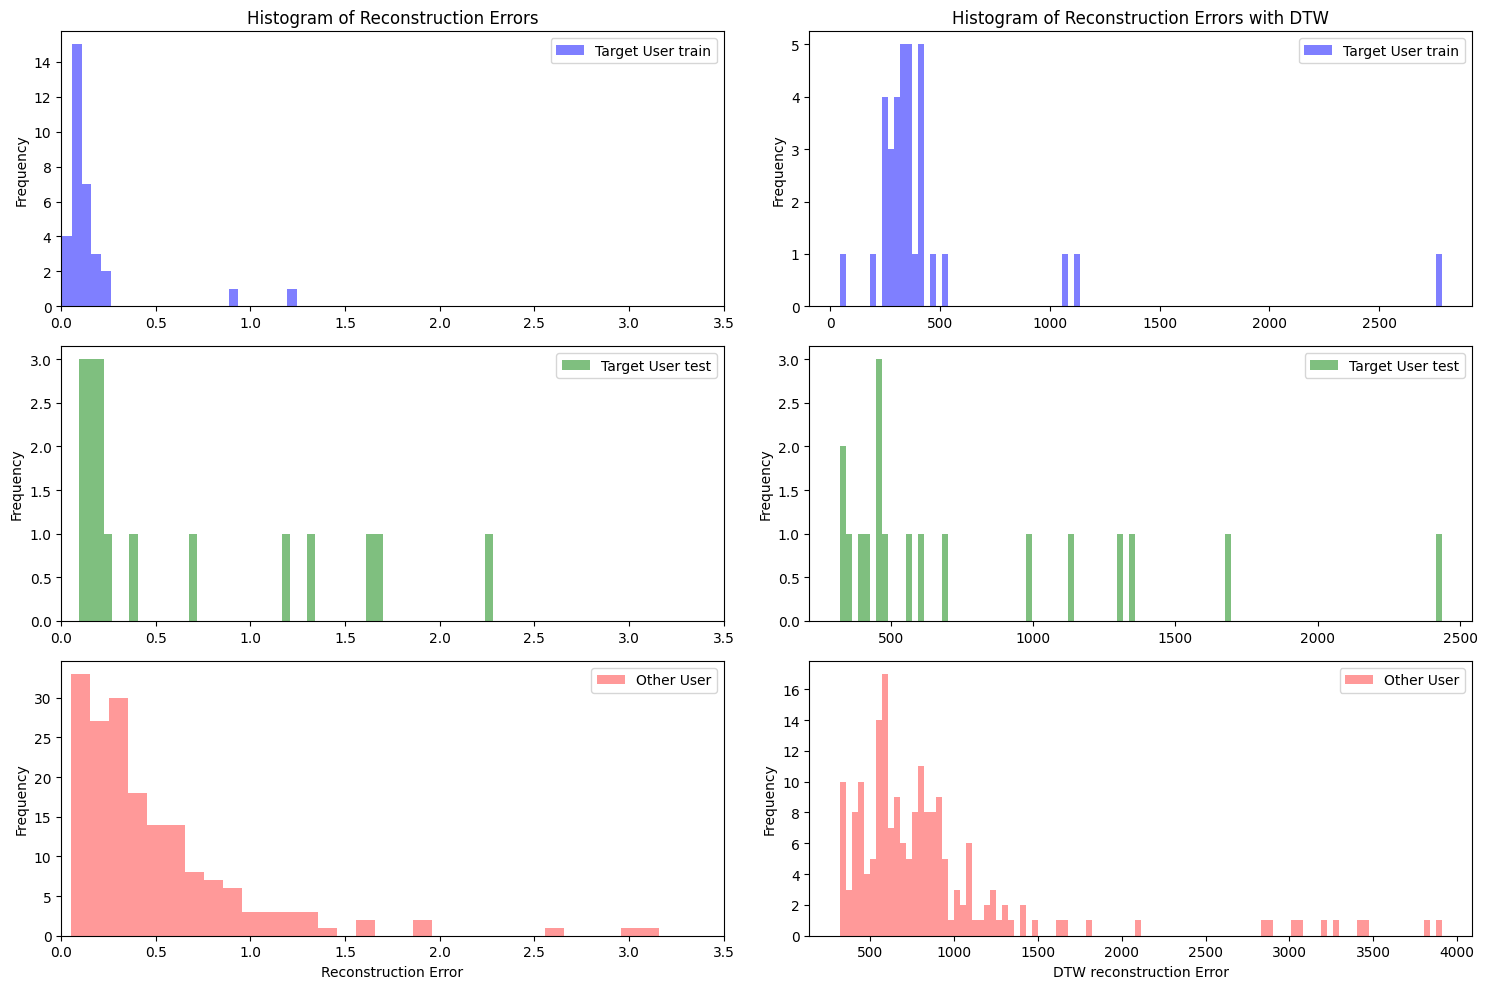

In [109]:
from fastdtw import fastdtw
autoencoder = autoencoder_target_0
# Calculate reconstruction errors for target_x_train
target_x_train_encoded = autoencoder.encoder(target_x_train).numpy()
target_x_train_decoded = autoencoder.decoder(target_x_train_encoded).numpy()
target_x_train_errors = np.mean(np.square(target_x_train - target_x_train_decoded), axis=(1, 2))
target_x_dtw = [fastdtw(target_x_train[i], target_x_train_decoded[i])[0] for i in range(len(target_x_train))]

# Calculate reconstruction errors for target_x_test
target_x_test_encoded = autoencoder.encoder(target_x_test).numpy()
target_x_test_decoded = autoencoder.decoder(target_x_test_encoded).numpy()
target_x_test_errors = np.mean(np.square(target_x_test - target_x_test_decoded), axis=(1, 2))
target_x_test_dtw = [fastdtw(target_x_test[i], target_x_test_decoded[i])[0] for i in range(len(target_x_test))]

# Calculate reconstruction errors for other_x_train
other_x_train_encoded = autoencoder.encoder(other_x_train).numpy()
other_x_train_decoded = autoencoder.decoder(other_x_train_encoded).numpy()
other_x_train_errors = np.mean(np.square(other_x_train - other_x_train_decoded), axis=(1, 2))
other_x_dtw = [fastdtw(other_x_train[i], other_x_train_decoded[i])[0] for i in range(len(other_x_train))]

# Calculate reconstruction errors for other_x_test
other_x_test_encoded = autoencoder.encoder(other_x_test).numpy()
other_x_test_decoded = autoencoder.decoder(other_x_test_encoded).numpy()
other_x_test_errors = np.mean(np.square(other_x_test - other_x_test_decoded), axis=(1, 2))
other_x_test_dtw = [fastdtw(other_x_test[i], other_x_test_decoded[i])[0] for i in range(len(other_x_test))]
                    
#calculate reconstruction errors for other_x_train_test
other_train_test = np.concatenate((other_x_train,other_x_test),axis=0)
other_train_test_encoded = autoencoder.encoder(other_train_test).numpy()
other_train_test_decoded = autoencoder.decoder(other_train_test_encoded).numpy()
other_train_test_errors = np.mean(np.square(other_train_test - other_train_test_decoded), axis=(1, 2))



fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# Plot histograms of Reconstruction Errors
axes[0, 0].set_title('Histogram of Reconstruction Errors')
axes[0, 0].set_xlim(0, 3.5)
axes[0, 0].hist(target_x_train_errors, bins=100, alpha=0.5, color='blue', label='Target User train')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

axes[1, 0].set_xlim(0, 3.5)
axes[1, 0].hist(target_x_test_errors, bins=100, alpha=0.5, color='green', label='Target User test')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

axes[2, 0].set_xlim(0, 3.5)
axes[2, 0].hist(other_x_train_errors, bins=100, alpha=0.4, color='red', label='Other User')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].legend()
axes[2, 0].set_xlabel('Reconstruction Error')

# Plot histograms of DTW Reconstruction Errors
axes[0, 1].set_title('Histogram of Reconstruction Errors with DTW')
axes[0, 1].hist(target_x_dtw, bins=100, alpha=0.5, color='blue', label='Target User train')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

axes[1, 1].hist(target_x_test_dtw, bins=100, alpha=0.5, color='green', label='Target User test')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

axes[2, 1].hist(other_x_dtw, bins=100, alpha=0.4, color='red', label='Other User')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].legend()
axes[2, 1].set_xlabel('DTW reconstruction Error')

# Adjust layout
plt.tight_layout()
plt.show()

In [148]:
print(all_x_test.shape)

(110, 100, 17)


In [147]:
hc2_pred = hc2.predict(all_x_test)
hc2_cm = confusion_matrix(all_y_test, hc2_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


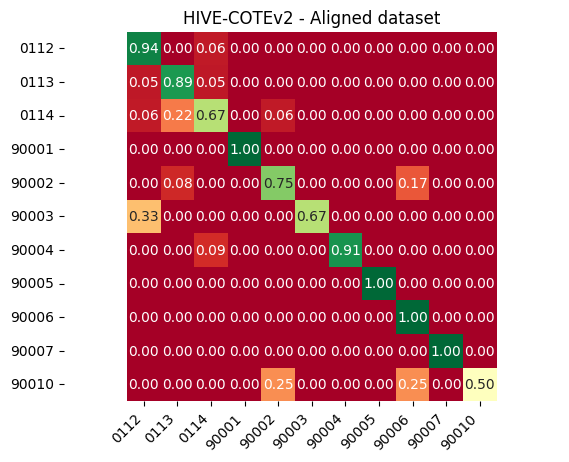

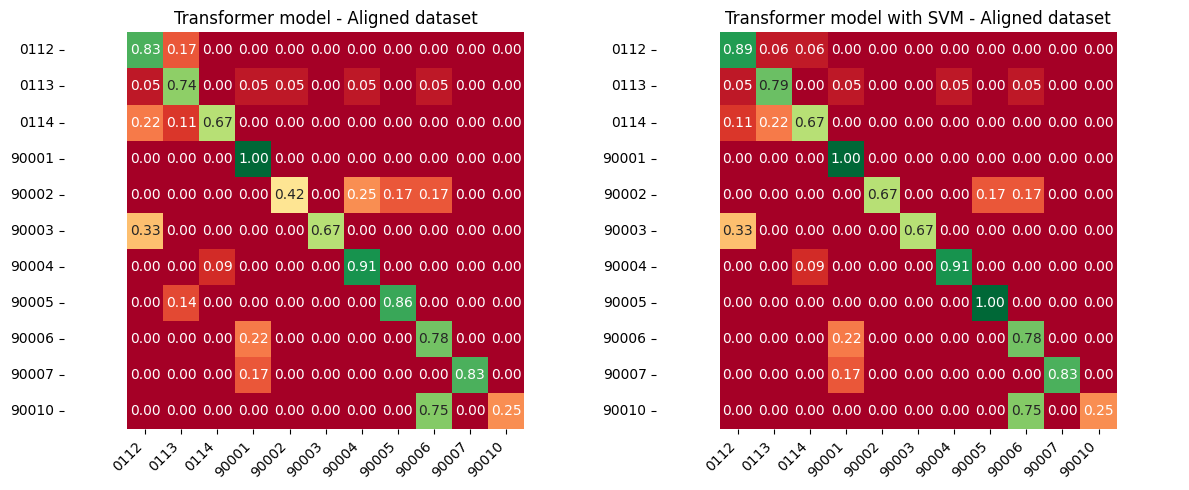

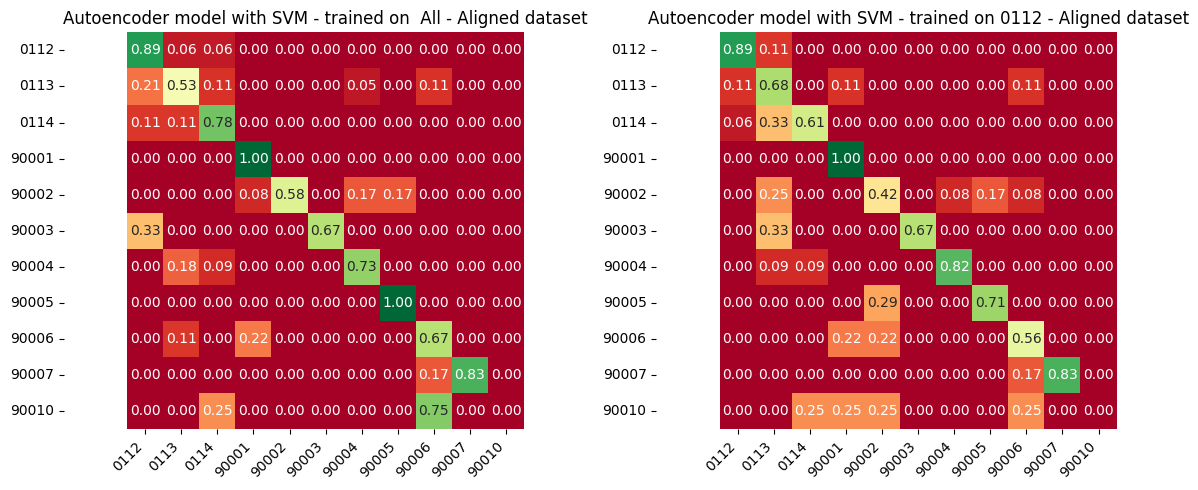

In [145]:
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
## hc2
hc2_pred = hc2.predict(all_x_test)
hc2_cm = confusion_matrix(all_y_test, hc2_pred)
## transformer
tr_pred = aligned_transformer.predict(all_x_test)
tr_predicted_classes = np.argmax(tr_pred, axis=1)
tr_cm = confusion_matrix(all_y_test, tr_predicted_classes)
## transformer as fe
tr_fe_train = aligned_transformer_encoder.predict(all_x_train)
tr_fe_test = aligned_transformer_encoder.predict(all_x_test)
tr_svm = SVC()
tr_svm.fit(tr_fe_train, all_y_train)
tr_svm_pred = tr_svm.predict(tr_fe_test)
tr_svm_cm = confusion_matrix(all_y_test, tr_svm_pred)
## autoencoder as fe
ae_fe_train = autoencoder_target_all.encoder.predict(all_x_train)
ae_fe_test = autoencoder_target_all.encoder.predict(all_x_test)
ae_svm = SVC()
ae_svm.fit(ae_fe_train, all_y_train)
ae_svm_pred = ae_svm.predict(ae_fe_test)
ae_svm_cm = confusion_matrix(all_y_test, ae_svm_pred)
## autoencoder_target_0 as fe
ae0_fe_train = autoencoder_target_0.encoder.predict(all_x_train)
ae0_fe_test = autoencoder_target_0.encoder.predict(all_x_test)
ae0_svm = SVC()
ae0_svm.fit(ae0_fe_train, all_y_train)
ae0_svm_pred = ae0_svm.predict(ae0_fe_test)
ae0_svm_cm = confusion_matrix(all_y_test, ae0_svm_pred)
######
plt.figure()
plt.axis('equal')
plt.title('HIVE-COTEv2 - Aligned dataset')
hc2_cm_pct = hc2_cm / hc2_cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(hc2_cm_pct, annot=True, fmt='.2f',cmap='RdYlGn', cbar=False, yticklabels=class_label_encoder.classes_)
plt.gca().set_xticklabels(class_label_encoder.classes_,rotation=45, ha='right')
plt.show()
####
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.axis('equal')
plt.title('Transformer model - Aligned dataset')
tr_cm_pct = tr_cm / tr_cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(tr_cm_pct, annot=True, fmt='.2f',cmap='RdYlGn', cbar=False, yticklabels=class_label_encoder.classes_)
plt.gca().set_xticklabels(class_label_encoder.classes_,rotation=45, ha='right')
###
plt.subplot(1, 2, 2)
plt.axis('equal')
plt.title('Transformer model with SVM - Aligned dataset')
tr_svm_pct = tr_svm_cm / tr_svm_cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(tr_svm_pct, annot=True, fmt='.2f',cmap='RdYlGn', cbar=False, yticklabels=class_label_encoder.classes_)
plt.gca().set_xticklabels(class_label_encoder.classes_,rotation=45, ha='right')
plt.tight_layout()
plt.show()
###
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.axis('equal')
plt.title('Autoencoder model with SVM - trained on  All - Aligned dataset')
ae_svm_cm_pct = ae_svm_cm / ae_svm_cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(ae_svm_cm_pct, annot=True, fmt='.2f',cmap='RdYlGn', cbar=False, yticklabels=class_label_encoder.classes_)
plt.gca().set_xticklabels(class_label_encoder.classes_,rotation=45, ha='right')
###
plt.subplot(1, 2, 2)
plt.axis('equal')
plt.title('Autoencoder model with SVM - trained on 0112 - Aligned dataset')
ae0_svm_cm_pct = ae0_svm_cm / ae0_svm_cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(ae0_svm_cm_pct, annot=True, fmt='.2f',cmap='RdYlGn', cbar=False, yticklabels=class_label_encoder.classes_)
plt.gca().set_xticklabels(class_label_encoder.classes_,rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [146]:
print("Classification report for transformer model")
print(sklearn.metrics.classification_report(all_y_test, tr_predicted_classes, target_names=class_label_encoder.classes_, zero_division=0))
print("Classification report for transformer model with SVM")
print(sklearn.metrics.classification_report(all_y_test, tr_svm_pred, target_names=class_label_encoder.classes_, zero_division=0))
print("Classification report for autoencoder - trained on all - with SVM")
print(sklearn.metrics.classification_report(all_y_test, ae_svm_pred, target_names=class_label_encoder.classes_, zero_division=0))
print("Classification report for autoencoder - trained on 0112 - with SVM")
print(sklearn.metrics.classification_report(all_y_test, ae0_svm_pred, target_names=class_label_encoder.classes_, zero_division=0))
print("Classification report for HIVE-COTEv2")
print(sklearn.metrics.classification_report(all_y_test, hc2_pred, target_names=class_label_encoder.classes_, zero_division=0))

Classification report for transformer model
              precision    recall  f1-score   support

        0112       0.71      0.83      0.77        18
        0113       0.70      0.74      0.72        19
        0114       0.92      0.67      0.77        18
       90001       0.43      1.00      0.60         3
       90002       0.83      0.42      0.56        12
       90003       1.00      0.67      0.80         3
       90004       0.71      0.91      0.80        11
       90005       0.75      0.86      0.80         7
       90006       0.54      0.78      0.64         9
       90007       1.00      0.83      0.91         6
       90010       1.00      0.25      0.40         4

    accuracy                           0.73       110
   macro avg       0.78      0.72      0.71       110
weighted avg       0.77      0.73      0.72       110

Classification report for transformer model with SVM
              precision    recall  f1-score   support

        0112       0.80      0.89  

In [ ]:

scaler = StandardScaler()

svm_model = SVC()
transformed_x_train = encoder.predict(x_train)
transformed_x_test = encoder.predict(x_test)
transformed_x_train = scaler.fit_transform(transformed_x_train)
transformed_x_test = scaler.transform(transformed_x_test)


svm_model.fit(transformed_x_train, y_train)
print(sklearn.metrics.classification_report(y_test, svm_model.predict(transformed_x_test)))